# 💬 **MLflow - Sentiment Analysis Classification** 🧐

## 📦 **Dependencies**

### Google Drive Paths

In [162]:
from pathlib import Path

# base directory for the project (current folder)
DATA_DIR = Path(".")

UTILS_NAME = "ai-utils"
DATASET_NAME = "Software_5.json.gz"
REQUIREMENTS_NAME = "requirements.txt"
ARTIFACTS_NAME = "artifacts"
TFIDF_VECTORIZER = "tfidf_vectorizer.pkl"
LOGREG_MODEL = "logreg_model"
NB_MODEL = "nb_model"
CONFUSION_MATRIX = "confusion_matrix.png"
CLASSIFICATION_REPORT = "classification_report.txt"
CLASSIFICATION_REPORT_NB = "classification_report_nb.txt"
CONFUSION_MATRIX_NB = "confusion_matrix_nb.png"

PATH_SOFTWARE_DS = DATA_DIR / DATASET_NAME
PATH_UTILS = DATA_DIR / UTILS_NAME
PATH_REQUIREMENTS = PATH_UTILS / REQUIREMENTS_NAME

# dataset
PATH_SOFTWARE      = DATA_DIR / "df_software.csv"
PATH_SOFTWARE_DEV  = DATA_DIR / "df_software_dev.csv"
PATH_SOFTWARE_TEST = DATA_DIR / "df_software_test.csv"
PATH_SOFTWARE_TEST_TARGET = DATA_DIR / "df_software_test_target.csv"

# mlflow
PATH_MLFLOW = DATA_DIR / "mlruns"
PATH_ARTIFACTS = DATA_DIR / ARTIFACTS_NAME

# artifacts
PATH_TFIDF_VECTORIZER = f"{PATH_ARTIFACTS}/tfidf_vectorizer.pkl"
PATH_IDF_SCORES = f"{PATH_ARTIFACTS}/idf_scores.csv"
PATH_IDF_SCORES_IMG = f"{PATH_ARTIFACTS}/idf_scores.png"
PATH_TOP_CHI2_WORDS_IMG = f"{PATH_ARTIFACTS}/top_chi2_words.png"
PATH_CV_RESULTS = f"{PATH_ARTIFACTS}/cv_results.csv"
PATH_EVAL_ARTIFACTS = f"{PATH_ARTIFACTS}/eval"

### My GitHub ai-utils Repo

**Note:**

I've created and modularized all the main steps of the project (EDA, preprocessing, and modeling) into reusable Python methods.
They're all available in my GitHub repo [`ai-utils`](https://github.com/syllerim/ai-utils), which I cloned and installed locally for this project.  

Feel free to check the links below to see exactly where each pipeline lives:

- [EDA pipeline → `nlp_eda_pipeline.py`](https://github.com/syllerim/ai-utils/blob/main/nlp/eda.py)
- [Preprocessing pipeline → `preprocessing_pipeline.py`](https://github.com/syllerim/ai-utils/blob/main/nlp/preprocessing.py)
- [Modeling pipeline → `nlp_modeling_pipeline.py`](https://github.com/syllerim/ai-utils/blob/main/nlp/modeling.py)


In [ ]:
import subprocess
import pkg_resources

package_name = "ai-utils"

if package_name in {pkg.key for pkg in pkg_resources.working_set}:
    subprocess.run(["pip", "uninstall", "-y", package_name])

In [ ]:
# clone ai-utils repo
!git clone https://github.com/syllerim/ai-utils.git

# install ai-utils in the folder created after cloning
# -e : editable mode, changes in the source reflect without reinstalling
!pip install -e ai-utils

In [ ]:
from pathlib import Path

# print(Path(PATH_REQUIREMENTS).exists())
subprocess.run(["pip", "install", "-r", str(Path(PATH_REQUIREMENTS))])

### Imports

In [105]:
import sys
from pathlib import Path

sys.path.append(PATH_UTILS)

from nlp.eda import run_eda_pipeline
from nlp.preprocessing import run_preprocessing_pipeline, remove_duplicate_reviews
from nlp.modeling import load_and_extract_tokens, process_and_save_splits_basic, inspect_review_tfidf
from nlp.modeling import plot_top_chi2_words, plot_precision_recall_vs_threshold, predict_review_sentiment

In [ ]:
import joblib
import matplotlib.pyplot as plt
import mlflow
import mlflow.pyfunc
import mlflow.sklearn

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from mlflow.models.signature import infer_signature
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report,f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud

In [107]:
# download the stopwords from nltk if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirellysd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
# mlflow.set_tracking_uri(f"file:{PATH_MLFLOW}")
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Sentiment Classification")

<Experiment: artifact_location='file:///Users/mirellysd/Documents/AI_Bootcamp/00_Practicas/12_MLOPS_LLMOPS/mlruns/684754209071336395', creation_time=1749933330718, experiment_id='684754209071336395', last_update_time=1749933330718, lifecycle_stage='active', name='Sentiment Classification', tags={}>

### Amazon software review dataset

In [109]:
import pandas as pd
import gzip
import json

data_path = "Software_5.json.gz"
data = []

with gzip.open(data_path, 'rt') as f:
    for line in f:
        data.append(json.loads(line))

df_software = pd.DataFrame(data)
print(df_software.shape)

(12805, 12)


## 🧭 **Exploratory Data Analysis**

In the following steps, I will apply my EDA pipeline to explore and analyze **Software** product review dataset.  
This will help uncover patterns in review length, sentiment distribution, vocabulary usage, and more.



--- Dataset loading and preprocessing --- 

First two rows:
 overall  verified  reviewTime     reviewerID       asin                   style reviewerName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

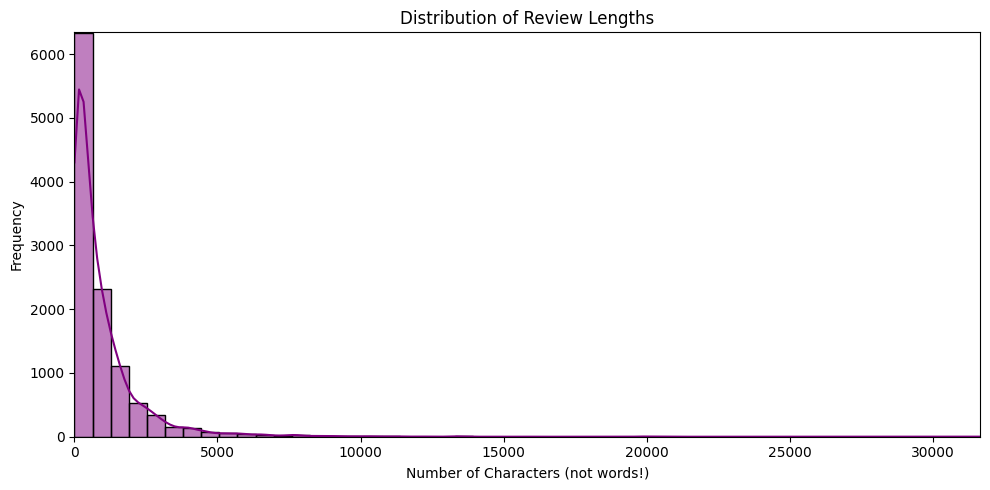


--- Vocabulary creation from tokenized text --- 
Sample tokenized reviews:

0    [i've, been, using, dreamweaver, (and, it's, p...
1    [the, demo, is, done, with, the, pc, version,,...
2    [if, you've, been, wanting, to, learn, how, to...
3    [i've, been, creating, websites, with, dreamwe...
4    [i, decided, (after, trying, a, number, of, ot...
Name: reviewText, dtype: object

Flattened list of all tokens (first 20):
0           i've
1           been
2          using
3    dreamweaver
4           (and
dtype: object

Vocabulary size: 64115

Top 20 most frequent words:
78831  the
58081  to
50807  and
45999  i
45198  a
31683  of
29451  it
28015  is
23697  you
23474  for
21361  that
20204  this
18809  in
17979  with
15353  have
14511  my
13894  on
11560  but
11126  as
10997  not
9923   was
9061   are
8865   be
8559   if
8254   can
8079   or
8036   your
7091   so
6951   software
6831   from

--- WordCloud to visually highlight the most frequent words in the reviews --- 


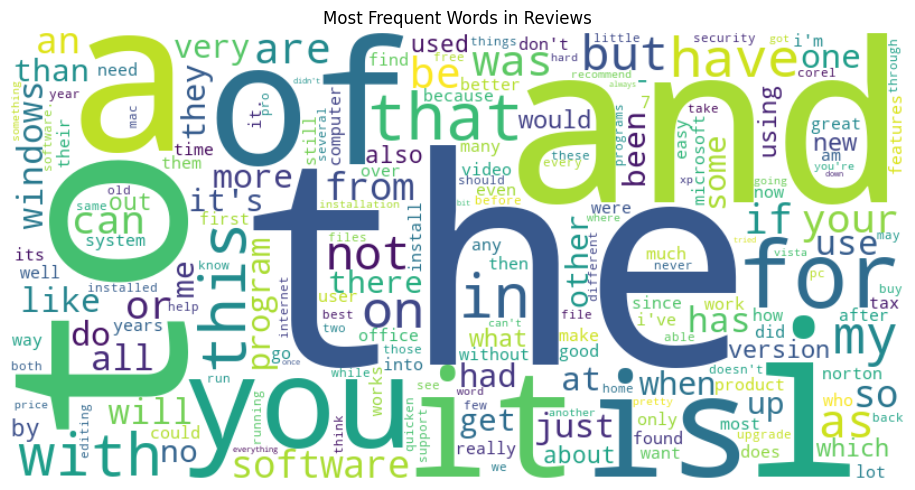


--- Distribution of reviews by sentiment --- 


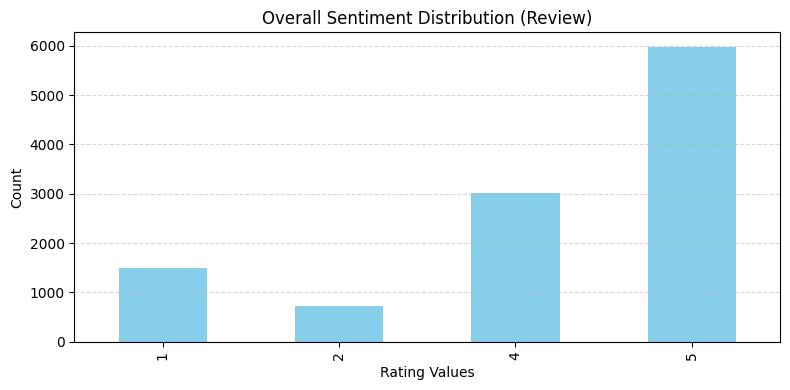

Plotting distribution of review scores (1 to 5, with 3 removed), keeping original score order.

--- Encode sentiment labels based on the 'overall' rating and visualize the class distribution --- 
Encoded 'sentiment_label' column:
                                          reviewText  overall  sentiment_label
0  I've been using Dreamweaver (and it's predeces...        4                1
1  The demo is done with the PC version, with ref...        4                1
2  If you've been wanting to learn how to create ...        5                1
3  I've been creating websites with Dreamweaver f...        5                1
4  I decided (after trying a number of other prod...        5                1




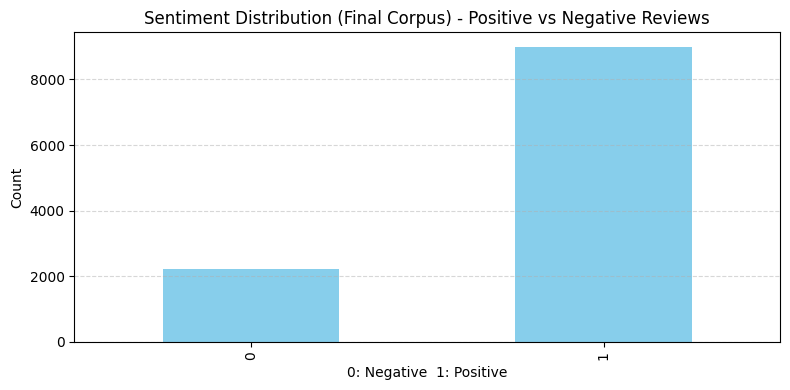

Plotting distribution of review scores (1 to 5, with 3 removed), keeping original score order.

--- Top 10 bigrams --- 
[(('of', 'the'), 6468), (('i', 'have'), 5233), (('in', 'the'), 4657), (('if', 'you'), 4591), (('is', 'a'), 3942), (('you', 'can'), 3650), (('it', 'is'), 3589), (('this', 'is'), 3234), (('to', 'the'), 2978), (('on', 'the'), 2922)]

Top 10 2-grams:
6468   of the
5233   i have
4657   in the
4591   if you
3942   is a
3650   you can
3589   it is
3234   this is
2978   to the
2922   on the


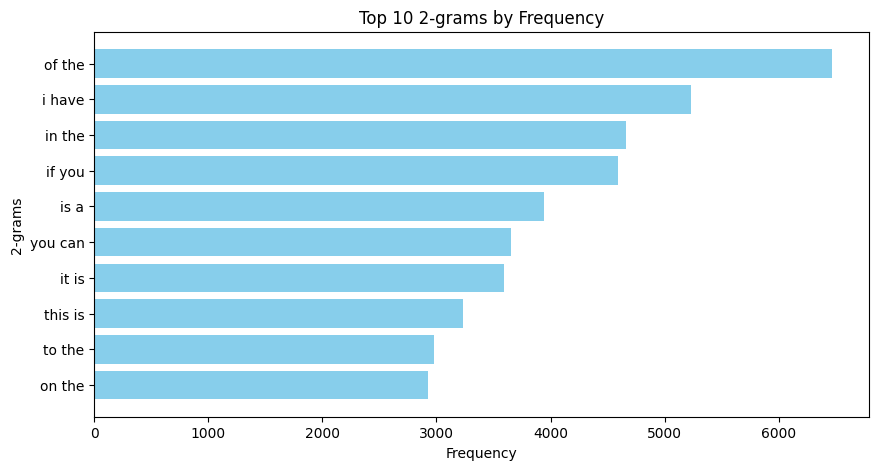


--- Top 10 trigrams --- 
[(('a', 'lot', 'of'), 1287), (('this', 'is', 'a'), 949), (('if', 'you', 'are'), 832), (('if', 'you', 'have'), 770), (('i', 'have', 'been'), 676), (('one', 'of', 'the'), 627), (('i', 'had', 'to'), 564), (('you', 'want', 'to'), 559), (('i', 'have', 'used'), 547), (('you', 'have', 'to'), 518)]

Top 10 3-grams:
1287   a lot of
949    this is a
832    if you are
770    if you have
676    i have been
627    one of the
564    i had to
559    you want to
547    i have used
518    you have to


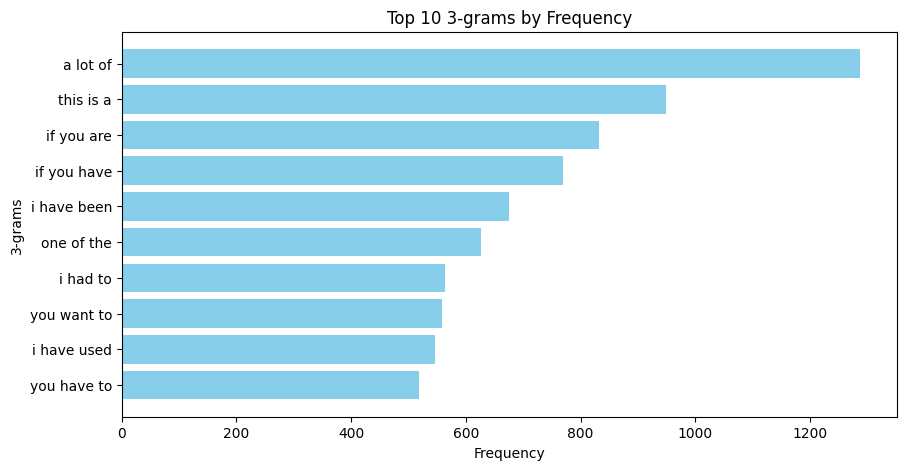

In [110]:
df_software, dfs_vocabulary, dfs_words, _, _ = run_eda_pipeline(PATH_SOFTWARE_DS)

### 💡 **Conclusions**

> 📊 **Distribution of Reviews**  
> The dataset follow a right-skewed distribution, meaning that most reviews are short (less than around 1000 characters) and only a few of them are very long (between 10k and 30k characters)
It may be useful to apply length trimming or normalization in subsequent preprocessing stages.

> 🔤 **Vocabulary**  
> The dataset is richer, with around 64K unique words.

> ☁️ **Word Cloud**  
> The word clouds are dominated by common stopwords (e.g., "the", "and", "to", "a"), which adds noise and makes it harder to identify meaningful patterns in the data.

> 🧠 **My Takes**  
> 👉 The dataset is highly imbalanced, with most reviews being positive. This could potentially bias any model trained on them. One option would be to apply balancing techniques before training. For now, I'll proceed with the imbalanced data, but if time allows, I may revisit the analysis using balanced datasets.  
> 👉 I will remove stopwords during preprocessing to better surface the most relevant terms used in the reviews.


## 🧹 **Preprocessing**

The result of the previous EDA steps contains contractions (e.g. i've, it's, etc), punctuations, possibly numbers and symbols, so it's not clean yet.
  
In this section I will clean the raw review texts to ensure a more meaningful and consistent vocabulary for downstream analysis by:
* Sentence normalization
* Tokenization
* Stopword removal
* Punctuation & number removal
* Stemming
* Removal of repetitions
* Remove very short tokens (e.g. length ≤ 2)
* Remove unwanted fragments (e.g. {'co', 'com', 'www', 'htt', 'th'}),
* Rebuilding the vocabulary with cleaned words.

In [111]:
df_software, tokenized_reviews_software, clean_flattened_tokens_software = run_preprocessing_pipeline(df_software)

🧹 Starting preprocessing of reviews...

- Tokenization and preprocessing complete.

- Flattened all tokens — total tokens: 727703

- Stored cleaned tokens in column 'cleaned_tokens'.

- Removed 2298 duplicate reviews.


In [112]:
df_software.shape

(8909, 5)

In [113]:
df_software.head(5)

,overall,reviewText,reviewLength,sentiment_label,cleaned_tokens
0,4,I've been using Dreamweaver (and it's predeces...,1237,1,"[use, dreamweav, predecessor, mani, someon, ex..."
1,4,"The demo is done with the PC version, with ref...",2439,1,"[demo, done, refer, mac, version, video, set, ..."
2,5,If you've been wanting to learn how to create ...,8410,1,"[want, learn, creat, either, lack, confid, aff..."
3,5,I've been creating websites with Dreamweaver f...,2475,1,"[creat, websit, dreamweav, year, experi, taugh..."
4,5,I decided (after trying a number of other prod...,1188,1,"[decid, tri, number, switch, gold, standard, w..."


In [114]:
# clean vocabulary

vocab_software = Counter(clean_flattened_tokens_software)
print(f"Vocabulary size: {len(set(clean_flattened_tokens_software))}")
print(f"\nVocabulary size: {len(vocab_software)}\n")
print("Top 20 most frequent words:")
for word, freq in vocab_software.most_common(20):
  print(f"{freq:<5}  {word}")

Vocabulary size: 12194

Vocabulary size: 12194

Top 20 most frequent words:
14080  use
6967   softwar
6258   program
6236   window
5950   like
5811   work
5638   get
5550   instal
5451   one
5060   version
4432   product
4234   need
3885   make
3862   time
3831   new
3819   would
3620   comput
3590   year
3548   also
3445   want


### 💡 **Conclusions**

> 📘 **Insights:**.
After running the preprocessing pipeline, the dataset were reduced in size. However, it retained **~8,900** cleaned and usable reviews. This makes this dataset a robust source for further analysis, model building, insight extraction, or any NLP experiments, thanks to its much larger volume of meaningful data.

> 🧠 **My Take:**.
> 👉 For the next section, I'll focus on working with the ***Software*** dataset for modeling. If time allows, I might also experiment with the other two, just to explore their behavior.


## 🏗️ **Split Metadata into Development and Test**

Run the full save and split pipeline for software dataset using my scripts in *nlp_modeling_pipeline.py*

In this step, I use the *process_and_save_splits* script to process and split the original dataset into two subsets (dev and test).

Each split is saved as a *.csv* file in the corresponding path for later use in the pipeline. The original dataset is also saved as a backup.

In [115]:
process_and_save_splits_basic(
    df=df_software,
    name="Software DS",
    target="sentiment_label",
    full_path=PATH_SOFTWARE,
    train_path=PATH_SOFTWARE_DEV,
    test_path=PATH_SOFTWARE_TEST,
    test_target_path=PATH_SOFTWARE_TEST_TARGET,
    test_size=0.25,
    random_state=0
)


📁 Processing dataset: Software DS
DataFrame with shape: (8909, 5) saved to: df_software.csv
Software DS train shape: (6681, 5), test shape: (2228, 5)
DataFrame with shape: (6681, 5) saved to: df_software_dev.csv
DataFrame with shape: (2228, 5) saved to: df_software_test.csv
DataFrame with shape: (2228, 1) saved to: df_software_test_target.csv


### 🏋️ **Train Splits**

In [116]:
# load the software train dataset saved on disk and get X and y

df_software_train, X_software_train, y_software_train = load_and_extract_tokens(
    PATH_SOFTWARE_DEV,
    'cleaned_tokens',
    'sentiment_label'
)

DataFrame loaded from: df_software_dev.csv with shape: (6681, 5)

Preview of features (cleaned_tokens):
0    ['receiv', 'card', 'difficult', 'microsoft', '...
1    ['norton', 'secur', 'work', 'use', 'norton', '...
2    ['mcafre', 'goe', 'far', 'beyond', 'stink', 'w...
3    ['bought', 'year', 'use', 'turbo', 'tax', 'pre...
4    ['realli', 'love', 'turbotax', 'bought', 'bloc...
Name: cleaned_tokens, dtype: object

Preview of labels (sentiment_label):
0    0
1    1
2    0
3    0
4    1
Name: sentiment_label, dtype: int64


### 🧪 **Test Splits** 🗂️

In [117]:
# load the software train dataset saved on disk and get X and y

df_software_test, X_software_test, y_software_test = load_and_extract_tokens(
    PATH_SOFTWARE_TEST,
    'cleaned_tokens',
    'sentiment_label'
)

DataFrame loaded from: df_software_test.csv with shape: (2228, 5)

Preview of features (cleaned_tokens):
0    ['total', 'trust', 'turbo', 'tax', 'correctli'...
1    ['test', 'use', 'everi', 'major', 'brand', 'in...
2    ['extend', 'capac', 'oper', 'system', 'support...
3    ['instal', 'window', 'machin', 'updat', 'progr...
4    ['use', 'car', 'car', 'kid', 'know', 'great', ...
Name: cleaned_tokens, dtype: object

Preview of labels (sentiment_label):
0    1
1    1
2    0
3    1
4    1
Name: sentiment_label, dtype: int64


This is a good point to check class balance

In [118]:
print("Class distribution (counts):")
print(y_software_train.value_counts())

print("\nClass distribution (percentage):")
print(y_software_train.value_counts(normalize=True).round(3))


Class distribution (counts):
1    5303
0    1378
Name: sentiment_label, dtype: int64

Class distribution (percentage):
1    0.794
0    0.206
Name: sentiment_label, dtype: float64


### 💡 **Conclusions**

> 🚨 This is a heavily imbalanced dataset:
> - **~20.6%** of samples are negative (0)
> - **~79.4%** are positive (1)  
>
> The consequences are:
> - This model can always predict 1 with 79.4% accuracy, despite never detecting correctly negative reviews.
>
> 🧠 **My Take**:   
> - When training model make sure to set the parameter `class_weight='balanced'` and compare results.



## 𝌭 **Modeling and Metrics**

### Feature Extraction with TF-IDF

To transform the preprocessed text into numerical features, I'll use **TF-IDF (Term Frequency - Inverse Document Frequency)**, which weighs the importance of a term in a document relative to how common it is in the entire corpus.

This setup helps keep things simple and efficient, which is important since working with limited data and resources.

The configuration I'm using is the following:

- `max_df=0.95`: Excludes very common terms that appear in more than 95% of the documents that most likely contain irrelevant info.
- `min_df=5`: Keep only words which appear in at least 5 documents, to remove noise.
- `max_features=3000`: Limit the vocabulary size to the top 3000 terms by importance, to control dimensionality and memory usage.
- `strip_accents='ascii'`: Clean up accents, turning words like “café” into “cafe”.
- `ngram_range=(1, 2)`: Pick up unigrams and bigrams to add a bit more context without adding too much overhead.

In [126]:
with mlflow.start_run(run_name="TFIDF_LogReg"):
    # log TF-IDF params
    mlflow.log_param("tfidf_max_df", 0.95)
    mlflow.log_param("tfidf_min_df", 5)
    mlflow.log_param("tfidf_max_features", 3000)
    mlflow.log_param("tfidf_strip_accents", "ascii")
    mlflow.log_param("tfidf_ngram_range", "(1, 2)")

    # fit the vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=5,
        max_features=3000,
        strip_accents='ascii',
        ngram_range=(1, 2)
    )
    tfidf_vectorizer.fit(X_software_train)

    # save the vectorizer to disk and log it in MLflow
    joblib.dump(tfidf_vectorizer, TFIDF_VECTORIZER)
    mlflow.log_artifact("tfidf_vectorizer.pkl", artifact_path=PATH_TFIDF_VECTORIZER)

mlflow.end_run()

In [127]:
# check the total number of unique tokens kept in the TF-IDF vocabulary
len(tfidf_vectorizer.vocabulary_)

3000

In [128]:
# print the first 20 vocabulary items
for word, index in list(tfidf_vectorizer.vocabulary_.items())[:10]:
    print(f"{index:<5}  {word}")

1979   receiv
307    card
562    difficult
1446   microsoft
1224   kept
2115   say
1859   product
1225   key
829    final
978    got


#### TF-IDF scores del training set y test set

In [129]:
X_software_train_tfidf = tfidf_vectorizer.transform(X_software_train)
X_software_test_tfidf = tfidf_vectorizer.transform(X_software_test)

In [130]:
# score IDF of some words

words_example = [
    'software',
    'bug',
    'error',
    'tutorial',
    'install',
    'update',
    'crash',
    'good',
    'bad',
    'co',       # invalid already filtered lengths
    'amazing',
    'horrible',
    'invalidword'
]

vocab_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

print(f"{'Word':20}{'IDF':>10}")
for word in words_example:
    if word not in vocab_idf:
        print(f"{word:20}{'OOV':>10}")
    else:
        print(f"{word:20}{vocab_idf[word]:>10.3f}")


Word                       IDF
software                   OOV
bug                      4.642
error                    4.470
tutorial                   OOV
install                    OOV
update                     OOV
crash                    4.286
good                     2.491
bad                      4.148
co                         OOV
amazing                    OOV
horrible                   OOV
invalidword                OOV


In [131]:
# create a df with the IDF scores for the example words
idf_df = pd.DataFrame.from_dict(vocab_idf, orient="index", columns=["idf"]).reset_index()
idf_df.columns = ["word", "idf"]
idf_df = idf_df[idf_df["word"].isin(words_example)]

In [132]:
# sort the df by IDF score in descending order, the higher the IDF score, the more informative the word is
idf_df.sort_values("idf", ascending=False)

,word,idf
276,bug,4.642387
704,error,4.469635
472,crash,4.285712
194,bad,4.147690
966,good,2.491289


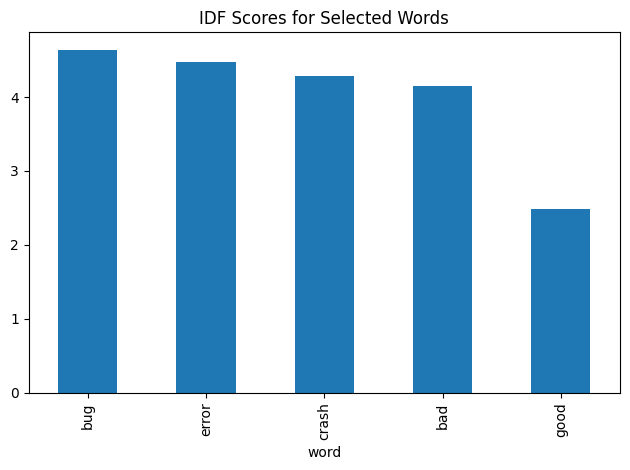

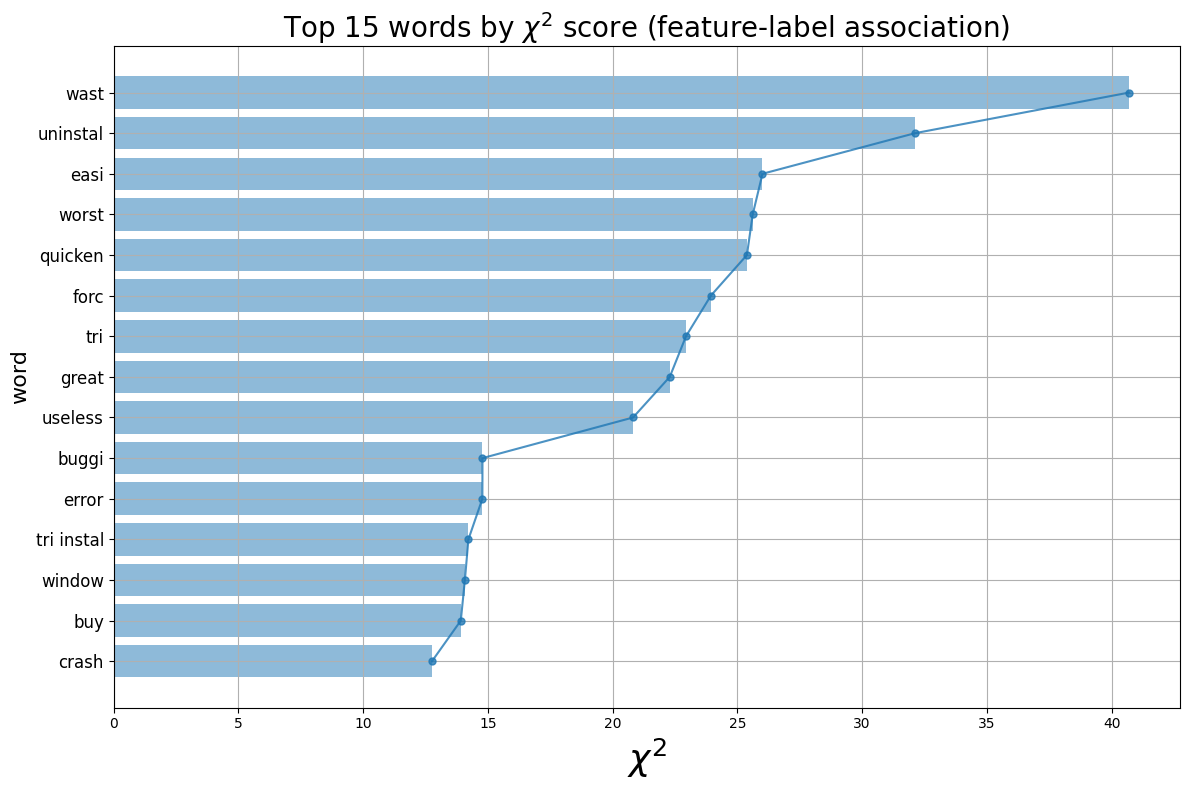

<Figure size 640x480 with 0 Axes>

In [135]:
with mlflow.start_run(run_name="TFIDF_IDF_Scores"):
    idf_df.to_csv("idf_scores.csv", index=False)
    mlflow.log_artifact("idf_scores.csv", artifact_path=PATH_IDF_SCORES)

    idf_df.sort_values("idf", ascending=False).plot.bar(x="word", y="idf", legend=False)
    plt.title("IDF Scores for Selected Words")
    plt.tight_layout()
    plt.savefig("idf_scores.png")
    mlflow.log_artifact("idf_scores.png", artifact_path=PATH_IDF_SCORES_IMG)

    # compute and plot the top N words with the highest Chi-squared score
    plot_top_chi2_words(X_software_train_tfidf, y_software_train, tfidf_vectorizer, top_n=15)
    plt.savefig("top_chi2_words.png")
    mlflow.log_artifact("top_chi2_words.png", artifact_path=PATH_TOP_CHI2_WORDS_IMG)

mlflow.end_run()

### Logistic Regression

In [192]:
def train_logistic_regresion_manual_search(X_train, y_train, X_test, y_test, path_eval):
    alpha_vector = np.logspace(-3, 3, 10) # from 10^(-3) to 10^3 in 10 values
    mlflow.set_experiment("Software_Sentiment_Analysis_Logistic_Regression_Manual_Search")

    best_acc = acc = 0
    best_C = None
    best_f1 = 0
    best_model = None
    best_prec = 0
    best_rec = 0
    best_y_pred = None

    for C in alpha_vector:
        with mlflow.start_run(run_name=f"LogisticRegression_C_{C:.4f}"):

            model = LogisticRegression(class_weight="balanced", max_iter=500, C=C)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            mlflow.log_param("model_type", "Logistic Regression")
            mlflow.log_param("class_weight", "balanced")
            mlflow.log_param("max_iter", "500")
            mlflow.log_param("C", C)
            mlflow.log_metric("accuracy", acc)
            mlflow.log_metric("precision", prec)
            mlflow.log_metric("recall", rec)
            mlflow.log_metric("f1_score", f1)

            # log all the model if needed for some reason
            # mlflow.sklearn.log_model(
            #     model, 
            #     artifact_path=LOGREG_MODEL, 
            #     signature=infer_signature(X_train, y_pred), 
            #     input_example=X_train[0]
            # )

            if f1 > best_f1:
                best_acc = acc
                best_C = C
                best_f1 = f1
                best_model = model
                best_prec = prec
                best_rec = rec
                best_y_pred = y_pred

    # log artifacts for best model
    with mlflow.start_run(run_name=f"LogReg_Best_C_{best_C:.4f}"):
        mlflow.log_param("best_C", best_C)
        mlflow.log_metric("best_f1_score", best_f1)

        # classification report
        report_txt = classification_report(y_test, best_y_pred, target_names=["negative", "positive"])
        with open(CLASSIFICATION_REPORT, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(CLASSIFICATION_REPORT, artifact_path=path_eval)

        # log confusion matrix plot as artifact
        cm = confusion_matrix(y_test, best_y_pred)

        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig(CONFUSION_MATRIX)
        plt.show()
        mlflow.log_artifact(CONFUSION_MATRIX, artifact_path=path_eval)
        plt.close()

        # log the best model artifact
        mlflow.sklearn.log_model(
            best_model, 
            artifact_path=LOGREG_MODEL, 
            signature=infer_signature(X_train, best_model.predict(X_train)), 
            input_example=X_train[0]
        )

    print(
        f"🤖 New best model found!\n"
        f"   Accuracy: {best_acc:.4f}\n"
        f"   C: {best_C}\n"
        f"   F1-score: {best_f1:.4f}\n"
        f"   Precision: {best_prec:.4f}\n"
        f"   Recall: {best_rec:.4f}\n"
    )

mlflow.end_run()

Call the function to train the logistic regression model with manual search - this ideally should be in a main funcion calling all the different steps from the entire experiment

🏃 View run LogisticRegression_C_0.0010 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/d7647e1be92b46f5a998253fdf587445
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/179441507385263668
🏃 View run LogisticRegression_C_0.0046 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/fc988f22a5f84ef9832331cf56057cd1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/179441507385263668
🏃 View run LogisticRegression_C_0.0215 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/7b1d057336eb4a51958a103c11819a7e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/179441507385263668
🏃 View run LogisticRegression_C_0.1000 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/a4cb1ad29fbd4688b56bafac483e6129
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/179441507385263668
🏃 View run LogisticRegression_C_0.4642 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/3982be141a5c49a2a2a3ba3971856d1d
🧪 View exper

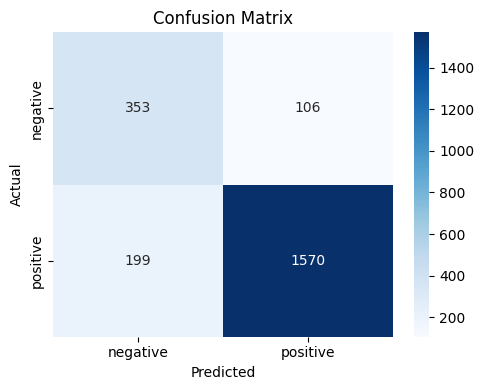

2025/06/15 10:37:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/f0/vk5jvtwj7x75k0xkxt9b3tx40000gn/T/tmpf_k280x5/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 


🏃 View run LogReg_Best_C_2.1544 at: http://127.0.0.1:8080/#/experiments/179441507385263668/runs/5ec8e5406ae4400f8b4f6994b8408f25
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/179441507385263668
🤖 New best model found!
   Accuracy: 0.8631
   C: 2.154434690031882
   F1-score: 0.9115
   Precision: 0.9368
   Recall: 0.8875



In [206]:
train_logistic_regresion_manual_search(
    X_software_train_tfidf,
    y_software_train,
    X_software_test_tfidf,
    y_software_test,
    PATH_EVAL_ARTIFACTS
)

We can see there is high precision and high recall because from all the positive, a huge ammount were predicted correctly, and from all the positive most of them were true positives.

### MultinomialNB - NaiveBayes

Based on the previous exercise I could even extract the code to evaluate and log a model, and then reuse it for different models.
With more time I would reuse it in the prev training with LogReg.

In [195]:
def evaluate_and_log_model(model, X_train, y_train, X_test, y_test, params, model_name=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if model_name is not None:
        mlflow.sklearn.log_model(
            model, 
            artifact_path=model_name, 
            signature=infer_signature(X_train, y_pred), 
            input_example=X_train[0]
        )

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    for key, value in params.items():
        mlflow.log_param(key, value)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)

    return model, y_pred, acc, f1, prec, rec

In [208]:
def train_naive_bayes_manual_search(X_train, y_train, X_test, y_test, path_eval):
    alpha_vector = np.logspace(-3, 3, 10)
    mlflow.set_experiment("Software_Sentiment_Analysis_NaiveBayes_Manual_Search")

    best_alpha = None
    best_acc = 0
    best_f1 = 0
    best_model = None
    best_prec = 0
    best_rec = 0
    best_y_pred = None

    for alpha in alpha_vector:
        with mlflow.start_run(run_name=f"NaiveBayes_alpha_{alpha:.4f}"):
            model = MultinomialNB(alpha=alpha)
            params = {"model_type": "MultinomialNB", "alpha": alpha}

            model, y_pred, acc, f1, prec, rec= evaluate_and_log_model(model, X_train, y_train, X_test, y_test, params) # model_name=f"nb_model_alpha_{alpha:.2f}") if want to log all the models

            if f1 > best_f1:
                best_alpha = alpha
                best_acc = acc
                best_f1 = f1
                best_model = model
                best_prec = prec
                best_rec = rec
                best_y_pred = y_pred

    # log artifacts for best model
    with mlflow.start_run(run_name=f"NaiveBayes_Best_alpha_{best_alpha:.4f}"):
        mlflow.log_param("best_alpha", best_alpha)
        mlflow.log_metric("best_f1_score", best_f1)

        # classification report
        report_txt = classification_report(y_test, best_y_pred, target_names=["negative", "positive"])
        with open(CLASSIFICATION_REPORT_NB, "w") as f:
            f.write(report_txt)
        mlflow.log_artifact(CLASSIFICATION_REPORT_NB, artifact_path=path_eval)

        # confusion matrix
        cm = confusion_matrix(y_test, best_y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig(CONFUSION_MATRIX_NB)
        mlflow.log_artifact(CONFUSION_MATRIX_NB, artifact_path=path_eval)
        plt.show()
        plt.close()

        # log the best model artifact
        mlflow.sklearn.log_model(
            best_model, 
            artifact_path=NB_MODEL, 
            signature=infer_signature(X_train, best_model.predict(X_train)), 
            input_example=X_train[0],
            registered_model_name="Software_Sentiment_Analysis_NB"
        )

    print(
        f"🤖 New best model found!\n"
        f"   Alpha: {best_alpha:.4f}\n"
        f"   Accuracy: {best_acc:.4f}\n"
        f"   F1-score: {best_f1:.4f}\n"
        f"   Precision: {best_prec:.4f}\n"
        f"   Recall: {best_rec:.4f}\n"
    )

mlflow.end_run()

🏃 View run NaiveBayes_alpha_0.0010 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/5ffc9ee2a7074430aabefcbf372b284b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/266023612068493226
🏃 View run NaiveBayes_alpha_0.0046 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/004a52c7324d4c6eb1dbe7097ab2e5b2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/266023612068493226
🏃 View run NaiveBayes_alpha_0.0215 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/808968625b9344c8af9c0d7a751fe4da
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/266023612068493226
🏃 View run NaiveBayes_alpha_0.1000 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/125f286090614a6ab87d83d7be17f5a2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/266023612068493226
🏃 View run NaiveBayes_alpha_0.4642 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/c241b20108d04392a9bab29998936b91
🧪 View experiment at: http://127

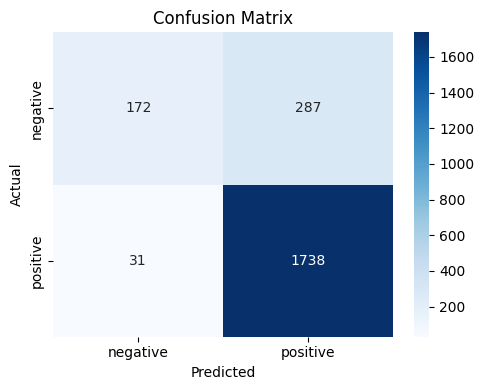

2025/06/15 10:43:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/f0/vk5jvtwj7x75k0xkxt9b3tx40000gn/T/tmp5m7x778n/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'Software_Sentiment_Analysis_NB'.
2025/06/15 10:43:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Software_Sentiment_Analysis_NB, version 1


🏃 View run NaiveBayes_Best_alpha_0.1000 at: http://127.0.0.1:8080/#/experiments/266023612068493226/runs/e6ec63b87fc241a182a3e2175e701838
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/266023612068493226
🤖 New best model found!
   Alpha: 0.1000
   Accuracy: 0.8573
   F1-score: 0.9162
   Precision: 0.8583
   Recall: 0.9825



Created version '1' of model 'Software_Sentiment_Analysis_NB'.


In [209]:
train_naive_bayes_manual_search(
    X_software_train_tfidf,
    y_software_train,
    X_software_test_tfidf,
    y_software_test,
    PATH_EVAL_ARTIFACTS
)

In [216]:
# Load the model from MLflow and make predictions
model = mlflow.pyfunc.load_model("models:/Software_Sentiment_Analysis_NB/Production")
model.predict(X_software_test_tfidf)

array([1, 1, 0, ..., 1, 1, 1])